In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_asl_mnist(with_augmentation=True):
    
    data_path = 'sign_mnist_train.csv'
    test_path = 'sign_mnist_test.csv'
    
    train_data = np.loadtxt(data_path, delimiter=',', skiprows=1)
    test_data = np.loadtxt(test_path, delimiter=',', skiprows=1)
    
    X_train, y_train = train_data[:, 1:], train_data[:, 0]
    X_test, y_test = test_data[:, 1:], test_data[:, 0]
    
    print("Unique labels before mapping (train):", np.unique(y_train))
    print("Unique labels before mapping (test):", np.unique(y_test))
    
    # Mapping for [0-25] excluding 9 (J) and 25 (Z)
    mapping = {
        0: 0,  1: 1,  2: 2,  3: 3,  4: 4,  5: 5,  6: 6,  7: 7,  8: 8,
        10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16,
        18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23
    }
    y_train = np.vectorize(mapping.get)(y_train)
    y_test = np.vectorize(mapping.get)(y_test)
    
    # Debug: Check unique labels after mapping
    print("Unique labels after mapping (train):", np.unique(y_train))
    print("Unique labels after mapping (test):", np.unique(y_test))
    
    # Normalize pixel values
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # Reshape images to 28x28
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=24)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=24)
    
    # Data augmentation
    if with_augmentation:
        datagen = ImageDataGenerator(
            rotation_range=10,          # Rotate images by up to 10 degrees
            width_shift_range=0.1,      # Horizontal shift
            height_shift_range=0.1,     # Vertical shift
            zoom_range=0.1,             # Zoom in/out
            shear_range=0.1,            # Shearing
            horizontal_flip=False       # Keep flip disabled for ASL
        )
        datagen.fit(X_train)  # Fit the generator to the training data
    else:
        datagen = None

    return X_train, y_train, X_test, y_test, datagen

In [3]:
# Load data and data generator
X_train, y_train, X_test, y_test, datagen = load_asl_mnist(with_augmentation=True)

Unique labels before mapping (train): [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
Unique labels before mapping (test): [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
Unique labels after mapping (train): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique labels after mapping (test): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [ ]:
def show_samples(X, y, num_samples=10):
    
    label_map = {
        0: 'A',  1: 'B',  2: 'C',  3: 'D',  4: 'E',  5: 'F',  6: 'G',  7: 'H',  8: 'I',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
        18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'
    }  
    
    indices = np.random.choice(X.shape[0], num_samples, replace=False)
    
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {label_map[np.argmax(y[idx])]}")  
        plt.axis('off')
    plt.tight_layout()
    plt.show()

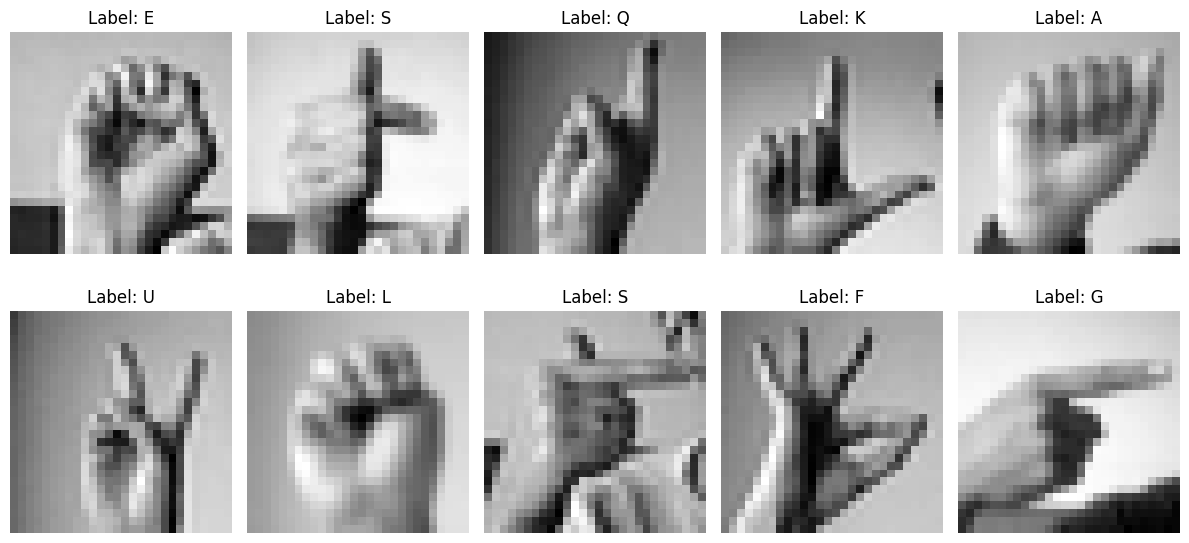

In [17]:
show_samples(X_train, y_train, num_samples=10)

In [6]:
def build_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(75, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Second Convolutional Block
        layers.Conv2D(100, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Third Convolutional Block
        layers.Conv2D(150, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.MaxPooling2D((2, 2), padding='same'),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(24, activation='softmax')  # 24 classes for A-Y (excluding J and Z)
    ])

    return model

In [ ]:
model = build_model()
print(model.summary())

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


batch_size = 32
steps_per_epoch = X_train.shape[0] // batch_size

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test),
    epochs=10
)


c:\Users\daksh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 100)    │        67,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 100)    │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 150)      │       135,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 150)      │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,229,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,448,472 (5.53 MB)

 Trainable params: 1,446,798 (5.52 MB)

 Non-trainable params: 1,674 (6.54 KB)

None


c:\Users\daksh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 174s 195ms/step - accuracy: 0.5189 - loss: 1.7445 - val_accuracy: 0.8744 - val_loss: 0.4098
Epoch 2/10
  1/857 ━━━━━━━━━━━━━━━━━━━━ 2:19 163ms/step - accuracy: 0.8125 - loss: 0.4496

c:\Users\daksh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


857/857 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8125 - loss: 0.4496 - val_accuracy: 0.8408 - val_loss: 0.5000
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 200s 234ms/step - accuracy: 0.9167 - loss: 0.2469 - val_accuracy: 0.9572 - val_loss: 0.1160
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9688 - loss: 0.0881 - val_accuracy: 0.9540 - val_loss: 0.1230
Epoch 5/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 214s 250ms/step - accuracy: 0.9595 - loss: 0.1248 - val_accuracy: 0.9375 - val_loss: 0.1711
Epoch 6/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9062 - loss: 0.1229 - val_accuracy: 0.9502 - val_loss: 0.1320
Epoch 7/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 237s 276ms/step - accuracy: 0.9677 - loss: 0.0992 - val_accuracy: 0.9459 - val_loss: 0.1625
Epoch 8/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9375 - loss: 0.0880 - val_accuracy: 0.9479 - val_loss: 0.1385
Epoch 9/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 259s 303ms/step - accuracy: 0.9737 - loss: 0.0775 - val

In [8]:
model.save("asl_model.h5")

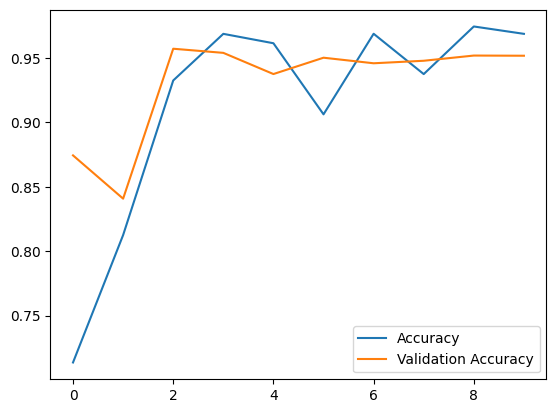

In [9]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()